# Initial Test

In [38]:
# Necessary imports
import numpy as np
import cv2
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from shapely.affinity import affine_transform

# from osgeo import gdal
from shapely.geometry import LineString
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.transform import Affine
import matplotlib.pyplot as plt

### Functions for scripts

In [84]:
def binarise_and_invert_array(arr, binarise_threshold=190):
    """
    Binarizes an image array and inverts the colors so that the background is white
    and features of interest are black.

    Parameters:
    - arr: Input image array (grayscale).
    - binarise_threshold: Threshold for binarizing the image (default is 190).

    Returns:
    - Inverted binary image.
    """
    assert arr.max() <= 255 and arr.min() >= 0
    assert 0 <= binarise_threshold <= 255

    # Binarize the image
    arr_bin = (
        arr < binarise_threshold
    )  # Features become white (True), background black (False)

    # Invert the binary image
    arr_inverted = ~arr_bin  # Features become black (True), background white (False)

    return arr_inverted

In [113]:
def detect_lines(input_image_path, binarise_threshold=190):
    """
    Detect lines in an image using the Canny algorithm and Hough Transform.
    Outputs a GeoDataFrame in pixel space.

    Parameters:
    - input_image_path: Path to the input image file.
    - binarise_threshold: Threshold for binarizing the image (default is 190).

    Returns:
    - gdf: GeoDataFrame with lines in pixel space.
    """
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        image_array = np.array(img)

    # Crop the image to remove border artifacts
    cropped_image = image_array[7:-7, 7:-7]

    # Binarize and invert the image
    binarized_image = binarise_and_invert_array(cropped_image, binarise_threshold)

    # Detect edges using Canny
    edges = canny(binarized_image, sigma=0.9, low_threshold=0.1, high_threshold=0.9)

    # Apply Hough Transform to detect lines
    lines = probabilistic_hough_line(edges, threshold=1, line_length=40, line_gap=10)

    # Convert lines to GeoDataFrame in pixel space
    line_geometries = [
        LineString([(x1, y1), (x2, y2)]) for ((x1, y1), (x2, y2)) in lines
    ]
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs=None)  # Pixel space, no CRS

    return gdf

In [ ]:
# Function to convert lines from pixel space to geographic space
def convert_lines_to_geographic_space(gdf, bounding_box, image_shape, crs="EPSG:4326"):
    """
    Convert lines from pixel space to geographic space.

    Parameters:
    - gdf: GeoDataFrame with lines in pixel space.
    - bounding_box: Tuple (xmin, ymin, xmax, ymax) in geographic space.
    - image_shape: Tuple (width, height) of the image in pixels.
    - crs: CRS for the output GeoDataFrame (default is EPSG:4326).

    Returns:
    - gdf_geographic: GeoDataFrame with lines in geographic space.
    """
    xmin, ymin, xmax, ymax = bounding_box
    width, height = image_shape

    # Calculate scaling factors
    scale_x = (xmax - xmin) / width
    scale_y = (ymax - ymin) / height

    # Map pixel coordinates to geographic coordinates
    def pixel_to_geographic(geom):
        return affine_transform(geom, (scale_x, 0, 0, -scale_y, xmin, ymax))

    # Transform geometry
    gdf_geographic = gdf.copy()
    gdf_geographic["geometry"] = gdf["geometry"].apply(pixel_to_geographic)
    gdf_geographic.crs = crs  # Set CRS to geographic CRS

    return gdf_geographic

In [ ]:
#### Rosie there may already be MR code that does this, but I'm not sure where it is! I've not actually looked :) ####


# Function to get metadata for a PNG image
def get_png_metadata(metadata_csv, png_name):
    """
    Extract the metadata for a specific PNG from the metadata CSV file.

    Parameters:
    - metadata_csv: Path to the metadata CSV file.
    - png_name: Name of the PNG file (e.g., "map_101433939.png").

    Returns:
    - metadata: Dictionary containing bounding box and other metadata.
    """
    metadata = pd.read_csv(metadata_csv)
    row = metadata[metadata["name"] == png_name]
    if row.empty:
        raise ValueError(f"No metadata found for {png_name}")

    # Parse the bounding box and return as a dictionary
    coords = eval(row["coordinates"].iloc[0])  # Convert string to tuple
    return {
        "bounding_box": coords,
        "crs": row["crs"].iloc[0],
        "image_name": row["name"].iloc[0],
    }

## Plot functions useful for MapReader?

In [75]:
# Function to plot detected lines
def plot_lines_on_image(input_image_path, gdf):
    """
    Plot detected lines in pixel space on the original image.

    Parameters:
    - input_image_path: Path to the input image file.
    - gdf: GeoDataFrame with lines in pixel space.
    """
    with Image.open(input_image_path) as img:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img, cmap="gray")

        # Plot the lines
        gdf.plot(ax=ax, color="red", linewidth=1)

        ax.set_title("Detected Lines")
        ax.axis("off")
        plt.show()

In [124]:
def plot_image_and_corrected_binarized(input_image_path, binarise_threshold=190):
    """
    Plot the original image and its corrected binarized version (features as black)
    side by side for visual comparison.

    Parameters:
    - input_image_path: Path to the input image file.
    - binarise_threshold: Threshold for binarizing the image (default is 190).
    """
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        original_image = np.array(img)

    # Crop the image to remove border artifacts
    # cropped_image = original_image[7:-7, 7:-7]

    # Correctly binarize and invert the cropped image
    binarized_image = binarise_and_invert_array(cropped_image, binarise_threshold)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(21, 21))
    ax = axes.ravel()

    # Original Image
    ax[0].imshow(cropped_image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Corrected Binarized Image
    ax[1].imshow(binarized_image, cmap="gray")
    ax[1].set_title(f"Binarized Image (Corrected, Threshold={binarise_threshold})")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

### Testing code

#### Step 1: Detect Lines in Pixel Space

In [118]:
input_image_path = "./data/6_inch_png/map_101433990.png"

# Detect lines in pixel space
gdf_pixel = detect_lines(input_image_path, binarise_threshold=190)
print(gdf_pixel.head())

                                            geometry
0  LINESTRING (1229.000 3013.000, 1181.000 3013.000)
1    LINESTRING (622.000 4159.000, 560.000 4159.000)
2    LINESTRING (820.000 1274.000, 779.000 1274.000)
3    LINESTRING (3614.000 372.000, 3702.000 292.000)
4       LINESTRING (45.000 1190.000, 3.000 1163.000)


#### Step 2: Convert Lines to Geographic Space (Optional)

In [119]:
# Metadata CSV
metadata_csv = "./data/6_inch_png/metadata.csv"

# Get metadata
metadata = get_png_metadata(metadata_csv, input_image_path.split("/")[-1])
bounding_box = metadata["bounding_box"]

# Convert lines to geographic space
image_shape = Image.open(input_image_path).size
gdf_geographic = convert_lines_to_geographic_space(gdf_pixel, bounding_box, image_shape)

# Print results
print(gdf_geographic.head())

                                            geometry
0  LINESTRING (-0.63775 51.04524, -0.63827 51.04524)
1  LINESTRING (-0.64427 51.03751, -0.64493 51.03751)
2  LINESTRING (-0.64214 51.05697, -0.64258 51.05697)
3  LINESTRING (-0.61217 51.06306, -0.61122 51.06360)
4  LINESTRING (-0.65046 51.05754, -0.65091 51.05772)


#### Step 3: Save as Shapefile (Optional)

In [120]:
output_shapefile = "./output/lines_geographic_space.shp"
gdf_geographic.to_file(output_shapefile)

#### Step 4: Plot the Detected Lines

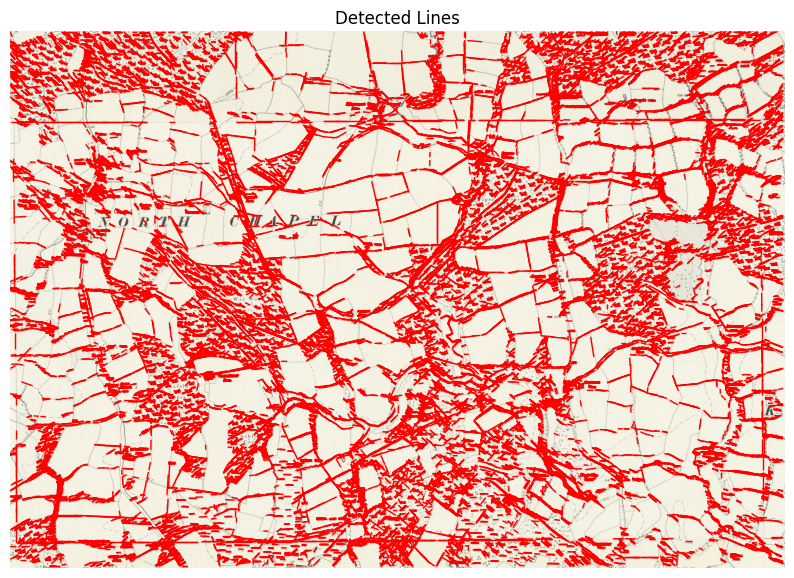

In [125]:
# Plot the detected lines in pixel space
plot_lines_on_image(input_image_path, gdf_pixel)

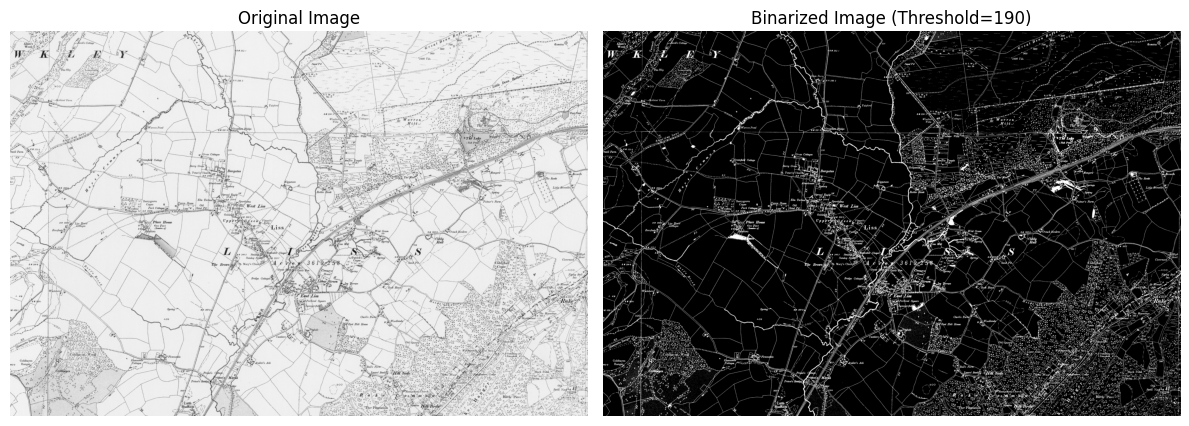

In [107]:
# Define the input image path
input_image_path = "./data/6_inch_png/map_101433939.png"

# Plot the original and binarized images side by side
plot_image_and_binarized(input_image_path, binarise_threshold=190)

In [114]:
def visualize_preprocessing(input_image_path, binarise_threshold=190):
    """
    Visualize the original image, binarized image, edge-detected image, and detected lines.

    Parameters:
    - input_image_path: Path to the input image file.
    - binarise_threshold: Threshold for binarizing the image (default is 190).
    """
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert("L")  # Convert to grayscale
        image_array = np.array(img)

    # Crop the image to remove border artifacts
    cropped_image = image_array[7:-7, 7:-7]

    # Binarize and invert the image
    binarized_image = binarise_and_invert_array(cropped_image, binarise_threshold)

    # Detect edges using Canny with original parameters
    edges = canny(binarized_image, sigma=0.9, low_threshold=0.1, high_threshold=0.9)

    # Detect lines using Hough Transform
    gdf_pixel = detect_lines(input_image_path, binarise_threshold)

    # Plot the results
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    ax = axes.ravel()

    # Original Image
    ax[0].imshow(cropped_image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Binarized Image
    ax[1].imshow(binarized_image, cmap="gray")
    ax[1].set_title("Binarized (Inverted) Image")
    ax[1].axis("off")

    # Edge-detected Image
    ax[2].imshow(edges, cmap="gray")
    ax[2].set_title("Edge-Detected Image")
    ax[2].axis("off")

    # Detected Lines
    ax[3].imshow(cropped_image, cmap="gray")
    for line in gdf_pixel.geometry:
        x, y = line.xy
        ax[3].plot(x, y, color="red")
    ax[3].set_title("Detected Lines")
    ax[3].axis("off")

    plt.tight_layout()
    plt.show()

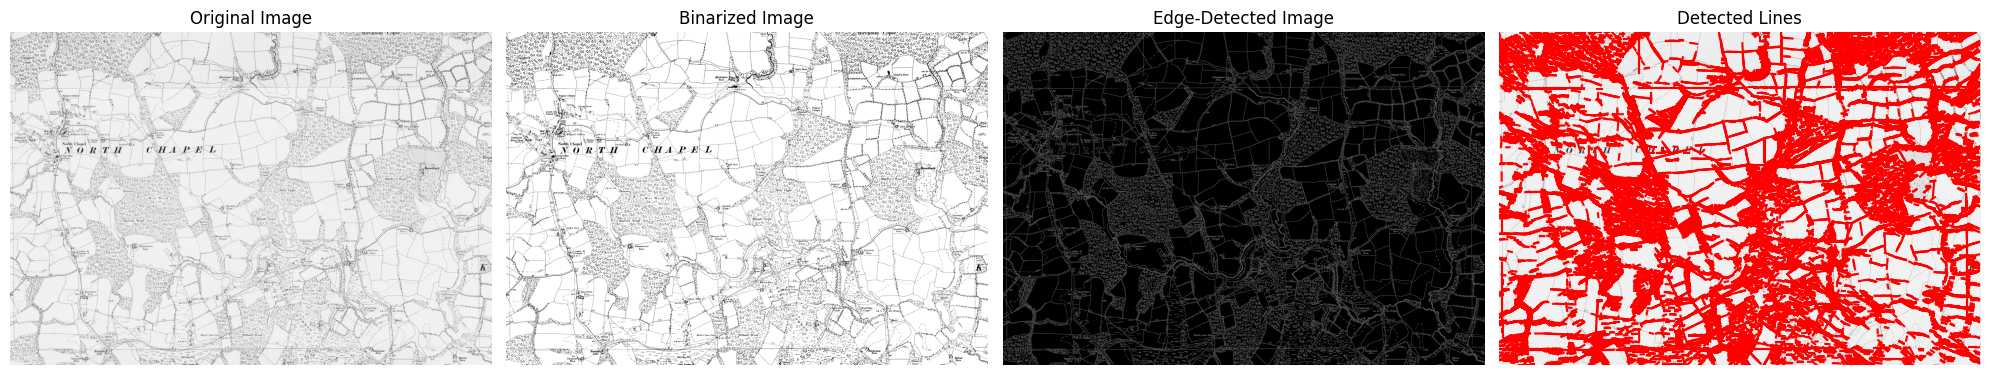

In [117]:
input_image_path = "./data/6_inch_png/map_101433990.png"

# Visualize the preprocessing steps
visualise_preprocessing(input_image_path, binarise_threshold=190)

In [14]:
# Load the image
im = PIL.Image.open("./data/6_inch_png/6 inch png/map_101433939.png")
im = im.convert("L")
ima = np.asarray(im)

## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
# arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
arr = arr[5:-5:][:, 5:-5]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(
    h=h, theta=theta, d=d, arr_bin=arr_bin
)

## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={"wspace": 0.1})

## Original image:
ax[0].imshow(arr, cmap="Greys_r")
ax[0].set_title("Input image in b/w", fontdict={"weight": "bold"}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title("Input image binarised", fontdict={"weight": "bold"}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title(
    "Detected straight-lines as vectors", fontdict={"weight": "bold"}, y=1.05
)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c="m", linewidth=3)

plt.tight_layout()

NameError: name 'hwi' is not defined